## Produit chimiques BC5CDR_chem

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys  
sys.path.insert(0, '/home/user/PPD_project/CRF')
from CFRs_functions import *

In [4]:
import nltk
import csv
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, pos_tag, pos_tag_sents
import nltk.tag
from sklearn.model_selection import learning_curve
from itertools import chain
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import pycrfsuite
import io
from collections import Counter

In [5]:
import sklearn_crfsuite
import eli5
import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite.metrics import sequence_accuracy_score,flat_accuracy_score, flat_recall_score,flat_precision_score

Using TensorFlow backend.


In [5]:
# Pos_tag_corpus : fonction pour ajouter les POS au corpus

In [6]:
corpus_training_with_pos = Pos_tag_corpus("BC5CDR-chem-IOBES/train.tsv")
corpus_testing_with_pos = Pos_tag_corpus("BC5CDR-chem-IOBES/test.tsv")
corpus_devel_with_pos = Pos_tag_corpus("BC5CDR-chem-IOBES/devel.tsv")

In [8]:
# Distrubition des tag 

In [7]:
tag_distribution = corpus_training_with_pos.groupby("tag").size().reset_index(name='counts')
print(tag_distribution)

          tag  counts
0  B-Chemical     777
1  E-Chemical     777
2  I-Chemical    1123
3           O  111066
4  S-Chemical    4425


In [8]:
## Save les données avec POS et Class
corpus_training_with_pos.to_csv('POS_BC5CDR/train_pos.tsv',sep='\t',index=False, header=False)
corpus_testing_with_pos.to_csv('POS_BC5CDR/test_pos.tsv',sep='\t',index=False, header=False)
corpus_devel_with_pos.to_csv('POS_BC5CDR/dev_pos.tsv',sep='\t',index=False, header=False)

In [10]:
corpus_training = corpus_preprocessing("POS_BC5CDR/train_pos.tsv")
corpus_testing = corpus_preprocessing("POS_BC5CDR/test_pos.tsv")
corpus_devel = corpus_preprocessing("POS_BC5CDR/dev_pos.tsv")

In [11]:
X_dev = sent2features(corpus_devel)
X_dev = [[i] for i in X_dev]
y_dev = sent2labels(corpus_devel)
y_dev = [[i] for i in y_dev]

In [12]:
## split_data_train_test : fonction pour spliter les datas 

In [13]:
X_train, y_train, X_test, y_test = split_data_train_test(corpus_training, corpus_testing)

## Train a CRF model

In [14]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
)
crf.fit(X_train, y_train);

In [15]:
import eli5
eli5.show_weights(crf, show=['targets'])

In [16]:
labels = list(crf.classes_)
labels.remove('O')
labels

['S-Chemical', 'B-Chemical', 'I-Chemical', 'E-Chemical']

In [17]:
## cross validation de model 

In [18]:
pred = cross_val_predict(estimator=crf, X = X_train,y = y_train, cv=10)

In [19]:
report = flat_classification_report(y_pred=pred, y_true=y_train)
print(report)
f1 = flat_f1_score(y_train, pred, average='weighted', labels=labels)
print("F1 weighted avg: " + str(f1))

              precision    recall  f1-score   support

  B-Chemical       0.81      0.44      0.57       777
  E-Chemical       0.80      0.54      0.64       777
  I-Chemical       0.78      0.43      0.55      1123
           O       0.98      1.00      0.99    111066
  S-Chemical       0.92      0.77      0.84      4425

    accuracy                           0.98    118168
   macro avg       0.86      0.63      0.72    118168
weighted avg       0.97      0.98      0.97    118168

F1 weighted avg: 0.7422085501553853


In [20]:
## On test sur les données test et dev 

In [21]:
y_pred = crf.predict(X_test)
flat_f1_score(y_test, y_pred,average='weighted', labels=labels)

0.7438295501304544

In [22]:
y_pred = crf.predict(X_dev)
flat_f1_score(y_dev, y_pred,average='weighted', labels=labels)

0.7575053202886658

In [23]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(flat_classification_report(
    y_dev, y_pred, labels=sorted_labels, digits=3
))

accuracy = flat_accuracy_score(y_dev, y_pred)
print("Accuracy: " + str(accuracy))
f1 = flat_f1_score(y_dev, y_pred, average='weighted', labels=labels)
precision = flat_precision_score(y_dev, y_pred, average='weighted', labels=labels)
print("Precision : "  + str(precision))

recall =flat_recall_score(y_dev, y_pred, average='weighted', labels=labels)
print("Recall : " + str(recall))
print("F1 weighted avg: " + str(f1))

              precision    recall  f1-score   support

  B-Chemical      0.757     0.511     0.610       724
  E-Chemical      0.822     0.579     0.680       725
  I-Chemical      0.675     0.379     0.486      1023
  S-Chemical      0.937     0.783     0.853      4622

   micro avg      0.882     0.676     0.766      7094
   macro avg      0.798     0.563     0.657      7094
weighted avg      0.869     0.676     0.758      7094

Accuracy: 0.9767394339815414
Precision : 0.8690597372004718
Recall : 0.6760642796729631
F1 weighted avg: 0.7575053202886658


## Plot learning curves for the optimised model

La performance du modèle peut être évaluée à l'aide d'une courbe d'apprentissage, en traçant la précision des prédictions sur les ensembles de données de formation et de test au fur et à mesure que des données de formation supplémentaires sont introduites dans le modèle. Comme on peut s'y attendre, la précision des données de test augmente avec le nombre d'échantillons de formation.

[learning_curve] Training set sizes: [ 7877 15755 23633 31511 39389 47266 55144 63022 70900 78778]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.1min finished


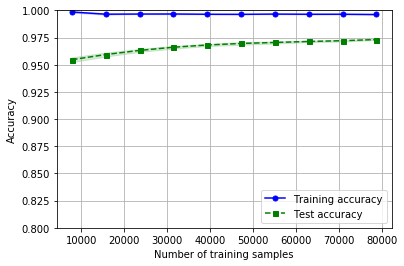

In [24]:
# Produce the necessary data for a learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=crf,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=3,
                                                        verbose=1,
                                                        n_jobs=-1)

# Find the means and standard deviations of the training and test datasets across the learning curve
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std)

In [26]:
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(flat_f1_score,average='weighted', labels=labels)
# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 22.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=0.1, c2=0.1,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_te...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f475d31dc90>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f475d31d690>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,


In [27]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.22305273698665823, 'c2': 0.026278282862165454}
best CV score: 0.7123445483600955
model size: 0.33M


In [28]:
crf = rs.best_estimator_
y_pred = crf.predict(X_dev)
print(flat_classification_report(
    y_dev, y_pred, labels=sorted_labels, digits=3
))

accuracy = flat_accuracy_score(y_dev, y_pred)
print("accuracy :" + str(accuracy))
precision = flat_precision_score(y_dev, y_pred, average='weighted', labels=labels)
print("Precision : "  + str(precision))
recall = flat_recall_score(y_dev, y_pred, average='weighted', labels=labels)
print("Recall : " + str(recall))
f1 = flat_f1_score(y_dev, y_pred, average='weighted', labels=labels)
print("F1 weighted avg: " + str(f1))

              precision    recall  f1-score   support

  B-Chemical      0.759     0.517     0.615       724
  E-Chemical      0.824     0.577     0.679       725
  I-Chemical      0.697     0.382     0.494      1023
  S-Chemical      0.934     0.788     0.855      4622

   micro avg      0.884     0.680     0.769      7094
   macro avg      0.804     0.566     0.661      7094
weighted avg      0.871     0.680     0.760      7094

accuracy :0.9770714845213364
Precision : 0.8709586008206355
Recall : 0.6804341697208909
F1 weighted avg: 0.7604626248066491


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Dark blue => 0.6292, dark red => 0.7123


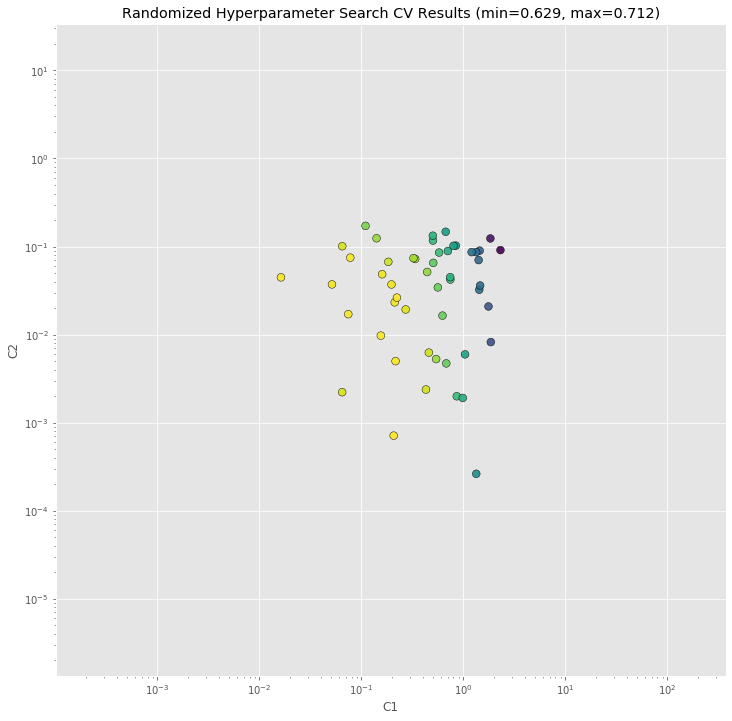

In [30]:
_x = rs.cv_results_['param_c1'].tolist()
_y = rs.cv_results_['param_c2'].tolist()
_c = rs.cv_results_['mean_test_score'].tolist()

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [31]:
crf = rs.best_estimator_
y_pred = crf.predict(X_dev)
print(flat_classification_report(
    y_dev, y_pred, labels = sorted_labels, digits = 3
))

              precision    recall  f1-score   support

  B-Chemical      0.759     0.517     0.615       724
  E-Chemical      0.824     0.577     0.679       725
  I-Chemical      0.697     0.382     0.494      1023
  S-Chemical      0.934     0.788     0.855      4622

   micro avg      0.884     0.680     0.769      7094
   macro avg      0.804     0.566     0.661      7094
weighted avg      0.871     0.680     0.760      7094



In [32]:
accuracy = flat_accuracy_score(y_dev, y_pred)
print("accuracy :" + str(accuracy))
precision = flat_precision_score(y_dev, y_pred, average='weighted', labels=labels)
print("Precision : "  + str(precision))
recall = flat_recall_score(y_dev, y_pred, average='weighted', labels=labels)
print("Recall : " + str(recall))
f1 = flat_f1_score(y_dev, y_pred, average='weighted', labels=labels)
print("F1 weighted avg: " + str(f1))

accuracy :0.9770714845213364
Precision : 0.8709586008206355
Recall : 0.6804341697208909
F1 weighted avg: 0.7604626248066491


In [33]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
10.349262 S-Chemical word.lower():bupropion
10.193630 I-Chemical +1:word.lower():berries
9.913566 S-Chemical word.lower():antidepressant
9.493425 S-Chemical word.lower():luminal
9.069332 E-Chemical -1:word.lower():vitamin
8.918005 I-Chemical word.lower():berries
8.680629 B-Chemical +1:word.lower():oxide
8.656890 E-Chemical -1:word.lower():o2
8.333610 S-Chemical word.lower():antidepressants
8.310443 S-Chemical word[-3:]:pam
8.203951 S-Chemical word[-3:]:dol
7.996143 B-Chemical +1:word.lower():contraceptives
7.981746 B-Chemical word.lower():cacl
7.855489 B-Chemical word.lower():tincture
7.835714 S-Chemical word[-3:]:lol
7.780043 S-Chemical word[-3:]:nol
7.478289 O        word.lower():saline
7.456112 S-Chemical word[-3:]:lam
7.327211 S-Chemical word[-3:]:NO
7.302728 S-Chemical word[-3:]:yde
7.242705 O        word.lower():baseline
7.147245 S-Chemical word.lower():steroid
7.141388 S-Chemical word.lower():disulfiram
7.127117 S-Chemical word.lower():bilirubin
7.014385 S-Chemical

In [34]:
## pycrfsuite

In [35]:
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

In [36]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 100,  # epoches

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [37]:
trainer.train('UG_NER_1203_1st.model')

In [38]:
tagger = pycrfsuite.Tagger()
tagger.open('UG_NER_1203_1st.model')

In [39]:
y_pred = [tagger.tag(xseq) for xseq in X_test]

In [40]:
X_test[0]

[{'bias': 1.0,
  'word.lower()': 'de',
  'word[-3:]': 'de',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'NNS',
  'postag[:2]': 'NN',
  'BOS': True,
  '+1:word.lower()': 'pointes',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'NNS',
  '+1:postag[:2]': 'NN'}]

In [41]:
%%time
y_pred = [tagger.tag(xseq) for xseq in X_dev]

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


In [42]:
print(bio_classification_report(y_dev, y_pred))

              precision    recall  f1-score   support

  B-Chemical       0.75      0.48      0.59       724
  E-Chemical       0.83      0.54      0.66       725
  I-Chemical       0.66      0.37      0.48      1023
  S-Chemical       0.93      0.77      0.84      4622

   micro avg       0.87      0.66      0.75      7094
   macro avg       0.79      0.54      0.64      7094
weighted avg       0.86      0.66      0.74      7094
 samples avg       0.04      0.04      0.04      7094



In [43]:
f1_2 = flat_f1_score(y_dev, y_pred, average='weighted', labels=labels)
print("F1 weighted avg: " + str(f1_2))

F1 weighted avg: 0.743430036753464
